Estimated catalyst volume = 0.20


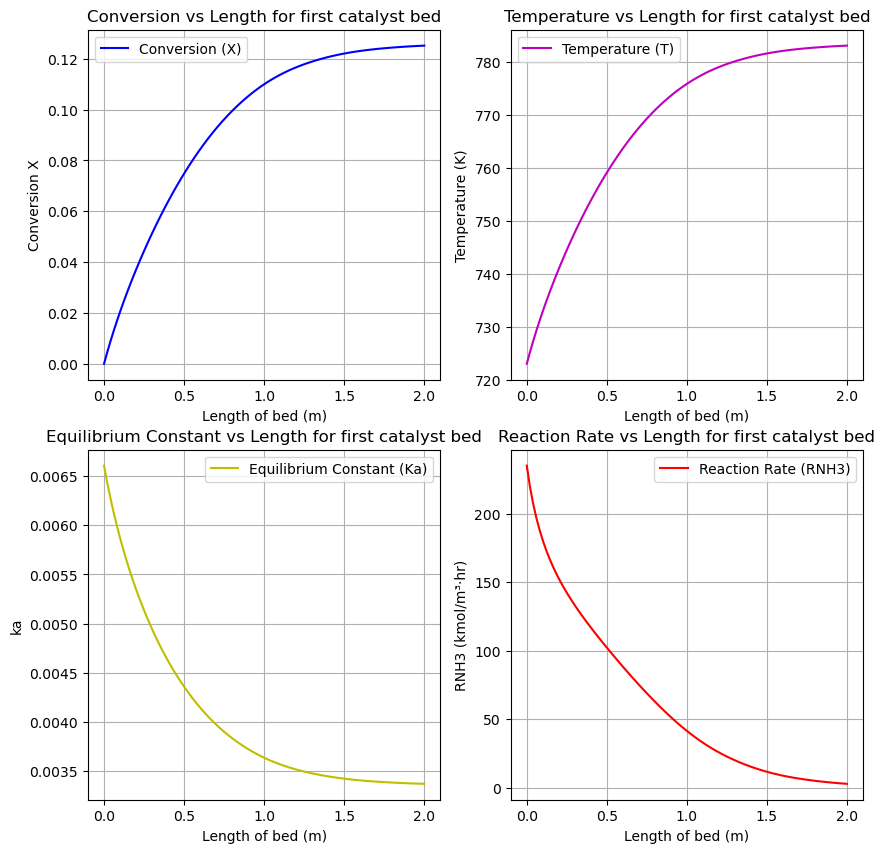

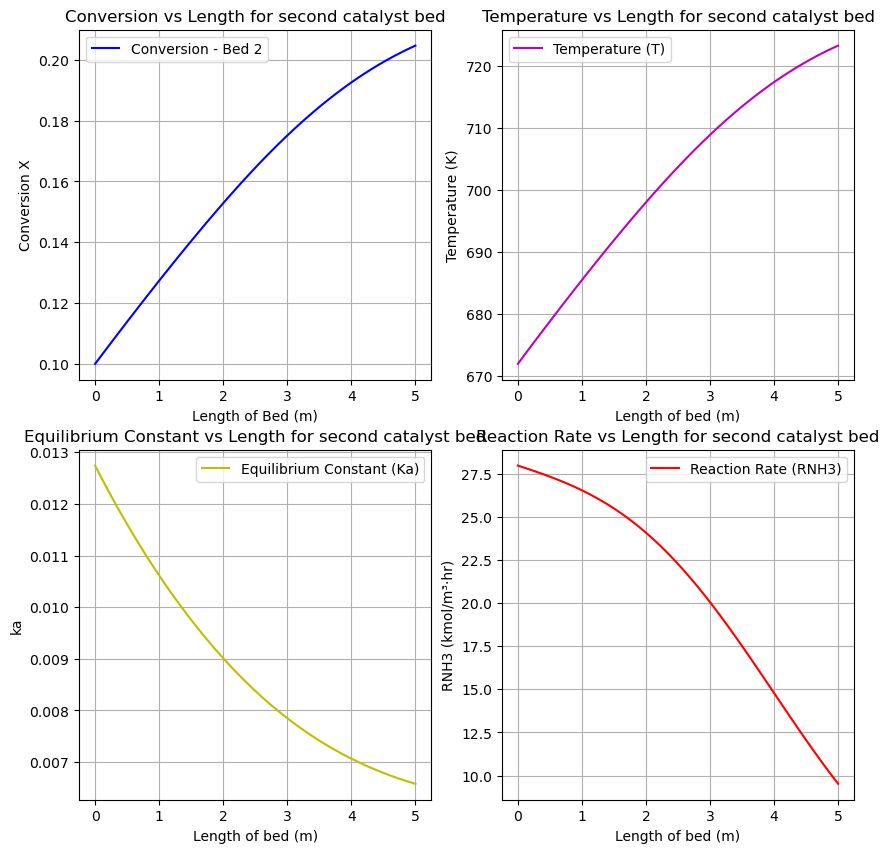

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import solve_ivp
from scipy.integrate import simpson

# Constants
# Cross-sectional area in m^2
A = 0.1
 
# In kmole/hr
FN2 = 49.79
FNH3 = 4.91
FTotal = 204.08

flow_rates = [0.8 * FTotal, 0.9 * FTotal, FTotal, 1.1 * FTotal, 1.2 * FTotal]
labels = ["163 kmole/hr", "184 kmole/hr", "Nominal load: 204 kmole/hr", "224 kmole/hr", "245 kmole/hr"]
colors = ["blue", "cyan", "green", "orange", "red"]

ko = 8.849e14
E = 170560
R = 8.314
alpha = 0.5
 
# Pressure values
PkPa = 10000
Pbar = 100
#Patm = Pbar * 0.986923
Patm = 98.69
 
# Mole fractions at the inlet to the reactor
YH2 = 0.7319
YN2 = 0.244
YNH3 = 0.0241

# Void fraction of catalyst bed 
VF = 0.4

# Desired final conversion across the reactor 
Xfinal = 0.15 

#Function to calculate output flow rate of Nitrogen after full 15% single pass conversion:
def compute_FN2out(FN2, Xfinal):
    return(FN2 - FN2 * Xfinal)

# Function to calculate output flow rate of Ammonia:
def compute_FNH3out(FNH3, FN2, Xfinal):
    return(FNH3 + 2 * FN2 * Xfinal)

# Function to calculate NH3 produced in kmol/hr:

def compute_NH3prod(FNH3, FNH3out):
    return(FNH3out - FNH3)
    

# Calculate partial pressure of ammonia pNH3(Patm)
def compute_pNH3(Patm, YNH3):
    return Patm * YNH3

#Polynomial coefficients for effectiveness factor n(T, X)
a0, a1, a2, b1, b2 = 0.03582, 8.366, 35.94, 7.705, 36.11

# Function to compute effectiveness factor n(T, X)
def compute_n(pNH3):
    return (a2 * pNH3**2 + a1 * pNH3 + a0)/(b2 * pNH3**2 + b1 * pNH3 +1)
 
# Function to compute equilibrium constant ka(T)
def compute_ka(T):
    logT = np.log10(T)
    return 10 ** (-2.691122 * logT - 5.519265e-5 * T + 1.848863e-7 * T**2 + 2001.6 / T + 2.689)
 
# Function to compute rate constant k(T)
def compute_k(ko, E, R, T):
    return ko * np.exp(-E / (R * T))

# Function to calculate fugacity coefficients
def compute_oH2(T, Patm):
    return np.exp(
        np.exp(-3.8402 * T**0.125 + 0.541) * Patm
        - np.exp(-0.1263 * T**0.5 - 15.98) * (Patm**2)
        + (300 * np.exp(-0.011901 * T - 5.941) * np.exp(-Patm / 300))
    )
 
def compute_oN2(T, Patm):
    return 0.93431737 + (0.2028538e-3) * T + (0.29589610e-3) * Patm - (0.270727e-6) * (T**2) + (0.4775207e-6) * (Patm**2)
 
def compute_oNH3(T, Patm):
    return 0.1438996 + (0.2028538e-2) * T - (0.4487672e-3) * Patm - (0.1142945e-5) * (T**2) + (0.2761216e-6) * (Patm**2)
 
# Functions to calculate mole fractions
def compute_yH2(YH2, YN2, X):
    return (YH2 - (3 * X * YN2)) / (1 - (2 * X * YN2))

def compute_yN2(YN2, X):
    return (YN2 * (1 - X)) / (1 - (2 * X * YN2))
 
def compute_yNH3(YNH3, X, YN2):
    return (YNH3 + (2 * X * YN2)) / (1 - (2 * X * YN2))
 
# Functions to calculate activation coefficients
def compute_aH2(yH2, oH2, Patm):
    return yH2 * oH2 * Patm
 
def compute_aN2(yN2, oN2, Patm):
    return yN2 * oN2 * Patm
 
def compute_aNH3(yNH3, oNH3, Patm):
    return yNH3 * oNH3 * Patm
 
# Function to calculate the rate equation based on nitrogen adsorption as the slow step
def compute_RNH3(k, ka, aH2, aN2, aNH3, alpha):
    return (2 * k) * ((((ka**2) * aN2) * (((aH2**3) / (aNH3**2)) ** alpha)) - ((aNH3**2) / (aH2**3)) ** (1 - alpha))
 
# Function to calculate specific heat of the reacting mixture

def compute_Cpmix(T, PkPa): # in kJ/kmol
    return 35.31 + 0.02 * T + 0.00000694 * (T**2) - 0.0056 * PkPa + 0.000014 * PkPa * T
    print (Cpmix)

# Heat of ammonia synthesis reaction 

def compute_HR(T, Patm): # in kJ/kmol
    return 4.184 * (
        -(0.54526 + 846.609 / T + 459.734e6 / T**3) * Patm
        - 5.34685 * T
        - 0.2525e-3 * T**2
        + 1.69197e-6 * T**3
        - 9157.09
    )


#Define the differential equations
def reactor_odes(L, y):
    X, T = y
    yNH3_val = compute_yNH3(YNH3, X, YN2)
    pNH3 = Patm * yNH3_val
    n = compute_n(pNH3)
    k = compute_k(ko, E, R, T)
    ka = compute_ka(T)
    oH2 = compute_oH2(T, Patm)
    oN2 = compute_oN2(T, Patm)
    oNH3 = compute_oNH3(T, Patm)
    yH2_val = compute_yH2(YH2, YN2, X)
    yN2_val = compute_yN2(YN2, X)
    aH2 = compute_aH2(yH2_val, oH2, Patm)
    aN2 = compute_aN2(yN2_val, oN2, Patm)
    aNH3 = compute_aNH3(yNH3_val, oNH3, Patm)
    RNH3 = compute_RNH3(k, ka, aH2, aN2, aNH3, alpha)
    HR = compute_HR(T, Patm)
    Cpmix = compute_Cpmix(T, Patm)
    dX_dL = (n * RNH3 * A) / (2 * FN2)
    dT_dL = (n * (-HR) * A * RNH3) / (FTotal * Cpmix)
    
    return [dX_dL, dT_dL]

# Initial conditions
X0 = 0
T0 = 723
y0 = [X0, T0]

# Integration limits
L_span = (0, 2)
L_eval = np.linspace(0, 2, 100)
 
# Solve equations
solution = solve_ivp(reactor_odes, L_span, y0, method='RK45', t_eval=L_eval)
L_values = solution.t
X_values, T_values = solution.y

# Second bed and after cooling, inlet conditions 
X_firstbed = 0.1
T_outletfirstbed = 772

Tcooled = T_outletfirstbed - 100

y0_second_bed = [X_firstbed, Tcooled]

# Limits 
L_span_second_bed = (0,5)
L_eval_second_bed = np.linspace(0,5,100)

# Solve equations 
solution_second_bed = solve_ivp(reactor_odes, L_span_second_bed, y0_second_bed, method='RK45', t_eval=L_eval_second_bed)
L_values_2 = solution_second_bed.t
X_values_2, T_values_2 = solution_second_bed.y 

# Compute equilibrium constants Ka bed 1 and bed 1 

ka_values = [compute_ka(T) for T in T_values]

ka_values_2 = [compute_ka(T) for T in T_values_2]

# Compute rate values bed 1 and bed 2 
RNH3_values = [
    compute_RNH3(
        compute_k(ko, E, R, T),
        compute_ka(T),
        compute_aH2(compute_yH2(YH2, YN2, X), compute_oH2(T, Patm), Patm),
        compute_aN2(compute_yN2(YN2, X), compute_oN2(T, Patm), Patm),
        compute_aNH3(compute_yNH3(YNH3, X, YN2), compute_oNH3(T, Patm), Patm),
        alpha
    )
    for X, T in zip(X_values, T_values)
]

RNH3_values_2 = [
    compute_RNH3(
        compute_k(ko, E, R, T),
        compute_ka(T),
        compute_aH2(compute_yH2(YH2, YN2, X), compute_oH2(T, Patm), Patm),
        compute_aN2(compute_yN2(YN2, X), compute_oN2(T, Patm), Patm),
        compute_aNH3(compute_yNH3(YNH3, X, YN2), compute_oNH3(T, Patm), Patm),
        alpha
    )
    for X, T in zip(X_values_2, T_values_2)
]


# Integration to obtain volume of catalyst  

dX_dL_vals = np.gradient(X_values, L_values)

# No division by zero 

dX_dL_vals[dX_dL_vals == 0] = 1e-10

dL_dX_vals = 1 / dX_dL_vals

L_total = simpson(y=dL_dX_vals, x=X_values)

V_total = A * L_total

print(f"Estimated catalyst volume = {V_total:.2f}")

# Plot graphs
plt.figure(figsize=(10, 10))

# Plot bed 1 conversion against length
plt.subplot(2, 2, 1)
plt.plot(L_values, X_values, label="Conversion (X)", color='b')
plt.xlabel("Length of bed (m)")
plt.ylabel("Conversion X")
plt.title("Conversion vs Length for first catalyst bed")
plt.legend()
plt.grid()

# Plot bed 1 temperature against length 
plt.subplot(2, 2, 2)
plt.plot(L_values, T_values, label="Temperature (T)", color='m')
plt.xlabel("Length of bed (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Length for first catalyst bed")
plt.legend()
plt.grid()

# Plotbed 1 Ka against reactor length
plt.subplot(2, 2, 3)
plt.plot(L_values, ka_values, label="Equilibrium Constant (Ka)", color='y')
plt.xlabel("Length of bed (m)")
plt.ylabel("ka")
plt.title("Equilibrium Constant vs Length for first catalyst bed")
plt.legend()
plt.grid()

# Plot bed 1 RNH3 against reactor length 
plt.subplot(2, 2, 4)
plt.plot(L_values, RNH3_values, label="Reaction Rate (RNH3)", color='r')
plt.xlabel("Length of bed (m)")
plt.ylabel("RNH3 (kmol/m³·hr)")
plt.title("Reaction Rate vs Length for first catalyst bed")
plt.legend()
plt.grid()

plt.show()

# Plot bed 2 conversion against length 
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(L_values_2, X_values_2, label="Conversion - Bed 2", color='b')
plt.xlabel("Length of Bed (m)")
plt.ylabel("Conversion X")
plt.title("Conversion vs Length for second catalyst bed")
plt.legend()
plt.grid()

# Plot bed 2 temperature against length 
plt.subplot(2, 2, 2)
plt.plot(L_values_2, T_values_2, label="Temperature (T)", color='m')
plt.xlabel("Length of bed (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Length for second catalyst bed")
plt.legend()
plt.grid()

# Plot bed 2 Ka against length
plt.subplot(2, 2, 3)
plt.plot(L_values_2, ka_values_2, label="Equilibrium Constant (Ka)", color='y')
plt.xlabel("Length of bed (m)")
plt.ylabel("ka")
plt.title("Equilibrium Constant vs Length for second catalyst bed")
plt.legend()
plt.grid()

# Plot bed 2 RNH3 against length 
plt.subplot(2, 2, 4)
plt.plot(L_values_2, RNH3_values_2, label="Reaction Rate (RNH3)", color='r')
plt.xlabel("Length of bed (m)")
plt.ylabel("RNH3 (kmol/m³·hr)")
plt.title("Reaction Rate vs Length for second catalyst bed")
plt.legend()
plt.grid()

plt.show()
 

In [3]:
# Solving reactor ODES for 5 different flow rates

def reactor_odes_flow(L, y):
    X, T = y
    yNH3_val = compute_yNH3(YNH3, X, YN2)
    pNH3 = Patm * yNH3_val
    n = compute_n(pNH3)
    k = compute_k(ko, E, R, T)
    ka = compute_ka(T)
    oH2 = compute_oH2(T, Patm)
    oN2 = compute_oN2(T, Patm)
    oNH3 = compute_oNH3(T, Patm)
    yH2_val = compute_yH2(YH2, YN2, X)
    yN2_val = compute_yN2(YN2, X)
    aH2 = compute_aH2(yH2_val, oH2, Patm)
    aN2 = compute_aN2(yN2_val, oN2, Patm)
    aNH3 = compute_aNH3(yNH3_val, oNH3, Patm)
    RNH3 = compute_RNH3(k, ka, aH2, aN2, aNH3, alpha)
    HR = compute_HR(T, Patm)
    Cpmix = compute_Cpmix(T, Patm)
    dX_dL = (n * RNH3 * A) / (2 * FN2)
    dT_dL = (n * (-HR) * A * RNH3) / (FTotal_change * Cpmix)
        
    return [dX_dL, dT_dL]
    
# Initial conditions
    X0 = 0
    T0 = 723
    y0 = [X0, T0]
    
# Reactor length 
    L_span = (0, 2)
    L_eval = np.linspace(0, 2, 100)
    
# Solve the ODEs
    solution = solve_ivp(reactor_odes_flow, L_span, y0, method='RK45', t_eval=L_eval)

    return solution.t, solution.y  

L_solutions = []
T_solutions = []
X_solutions = []

for flow in flow_rates:
    L_vals, Y_vals = solve_reactor_with_flow(flow)
    X_vals = Y_vals[0]  #
    T_vals = Y_vals[1]  
    
    L_solutions.append(L_vals)
    T_solutions.append(T_vals)
    X_solutions.append(X_vals)

# Plotting temperature vs length for different flow rates 

plt.figure(figsize=(8, 6))

for L_vals, T_vals, label, color in zip(L_solutions, T_solutions, labels, colors):
    plt.plot(L_vals, T_vals, label=f"Flow {label}", color=color)

plt.xlabel("Length of Bed (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Length for Different Inlet Flow Rates")
plt.legend()
plt.grid()
plt.show()

# Plotting conversion vs length for different flow rates

plt.figure(figsize=(8, 6))

for L_vals, X_vals, label, color in zip(L_solutions, X_solutions, labels, colors):
    plt.plot(L_vals, X_vals, label=f"Flow {label}", color=color)

plt.xlabel("Length of Bed (m)")
plt.ylabel("Conversion (X)")
plt.title("Conversion vs Length for Different Inlet Flow Rates")
plt.legend()
plt.grid()
plt.show()  

NameError: name 'solve_reactor_with_flow' is not defined

In [33]:
#Printing the intial conditions of k,Ka,a_N2,a_H2,a_NH3 

X_init = X0
T_init = T0

# Compute mole fractions
yH2_init = compute_yH2(YH2, YN2, X_init)
yN2_init = compute_yN2(YN2, X_init)
yNH3_init = compute_yNH3(YNH3, X_init, YN2)

# Compute fugacity coefficients
oH2_init = compute_oH2(T_init, Patm)
oN2_init = compute_oN2(T_init, Patm)
oNH3_init = compute_oNH3(T_init, Patm)

# Compute activities
aH2_init = compute_aH2(yH2_init, oH2_init, Patm)
aN2_init = compute_aN2(yN2_init, oN2_init, Patm)
aNH3_init = compute_aNH3(yNH3_init, oNH3_init, Patm)

# Compute k and Ka
k_init = compute_k(ko, E, R, T_init)
Ka_init = compute_ka(T_init)

# Compute RNH3 
RNH3_init = compute_RNH3(k_init, Ka_init, aH2_init, aN2_init, aNH3_init, alpha)


print("\n--- Initial Conditions ---")
print(f"k = {k_init:.4e}")
print(f"Ka = {Ka_init:.4e}")
print(f"a_N2 = {aN2_init:.4f}")
print(f"a_H2 = {aH2_init:.4f}")
print(f"o_NH3 = {oNH3_init:.4f}")
print(f"yNH3_init = {yNH3_init:.4f}")
print(f"a_NH3 = {aNH3_init:.4f}")
print(f"RNH3_init = {RNH3_init:.4f}")


--- Initial Conditions ---
k = 4.2071e+02
Ka = 6.6057e-03
a_N2 = 23.4378
a_H2 = 74.2133
o_NH3 = 0.9715
yNH3_init = 0.0241
a_NH3 = 2.3106
RNH3_init = 235.0612


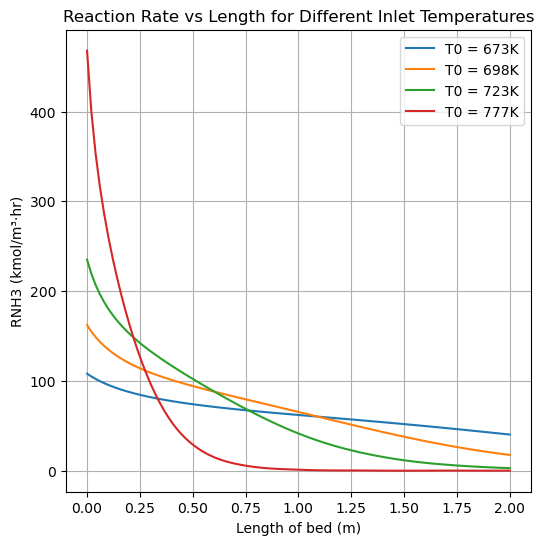

In [4]:
# Code to plot reaction rate vs length for 3 inlet temperatures 
# Initial conditions for testing different inlet temperatures 
X0 = 0
T0_list = [673, 698, 723, 777]

plt.figure(figsize=(6,6))

for T0 in T0_list:
    y0 = [X0, T0]
# solve the X and T values for the list 
    solution = solve_ivp(reactor_odes, L_span, y0, method='RK45', t_eval=L_eval)
    L_values = solution.t
    X_values, T_values = solution.y

    RNH3_values = [
        compute_RNH3(
            compute_k(ko, E, R, T),
            compute_ka(T),
            compute_aH2(compute_yH2(YH2, YN2, X), compute_oH2(T, Patm), Patm),
            compute_aN2(compute_yN2(YN2, X), compute_oN2(T, Patm), Patm),
            compute_aNH3(compute_yNH3(YNH3, X, YN2), compute_oNH3(T, Patm), Patm),
            alpha
        )
        for X, T in zip(X_values, T_values)
    ]

    plt.plot(L_values, RNH3_values, label=f"T0 = {T0}K")

# plot graph
plt.xlabel("Length of bed (m)")
plt.ylabel("RNH3 (kmol/m³·hr)")
plt.title("Reaction Rate vs Length for Different Inlet Temperatures")
plt.legend()
plt.grid()
plt.savefig('RDIFFT.png')
